In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout

import matplotlib.pyplot as plt
import re
import seaborn as sns

In [ ]:
df = pd.read_csv('/LIAR_preprocessed_nolemma.csv')
df.text = df.text.astype(str)

In [3]:
X = df['text']
y = df['Label']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [5]:
# Tokenizing text
vocab = 10000
tokenizer = Tokenizer(num_words= vocab)
tokenizer.fit_on_texts(X_train)

# Text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=128)
X_test_padded = pad_sequences(X_test_sequences, maxlen=128)

In [6]:
#WORD EMBEDDINGS FROM GLOVE PRE-TRAINED SET

embedding_path = "D:/Glove_DeepLearning/glove.6B.300d.txt"
embedding_dim = 300
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
num_words = len(tokenizer.word_index)
nb_words = min(num_words, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embedding_dim))
for word, i in word_index.items():
    if i >= num_words: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

F:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [8]:
model = Sequential()
model.add(Embedding(15167, 300, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(16)))
tf.keras.layers.Dense(64, activation='relu')
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compile
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         4550100   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,755,573
Trainable params: 4,755,573
No

In [10]:
# Train the model
history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=8, batch_size=30, callbacks=[earlystop])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/8
213/213 [==============================] - 33s 153ms/step - loss: 0.5852 - accuracy: 0.7023 - val_loss: 0.6224 - val_accuracy: 0.6757
Epoch 2/8
213/213 [==============================] - 34s 158ms/step - loss: 0.4735 - accuracy: 0.7898 - val_loss: 0.6878 - val_accuracy: 0.6455
Epoch 3/8
50/50 [==============================] - 2s 38ms/step - loss: 0.6224 - accuracy: 0.6757
Train Loss: 0.4633101522922516
Train Accuracy: 0.798431396484375
Test Loss: 0.6223838925361633
Test Accuracy: 0.6756587028503418


[0.5852124094963074, 0.4735386371612549, 0.35257968306541443]
[0.6223838925361633, 0.6877638101577759, 0.717750072479248]
[0.7022745013237, 0.7898039221763611, 0.8613333106040955]
[0.6756587028503418, 0.6455457806587219, 0.6562107801437378]


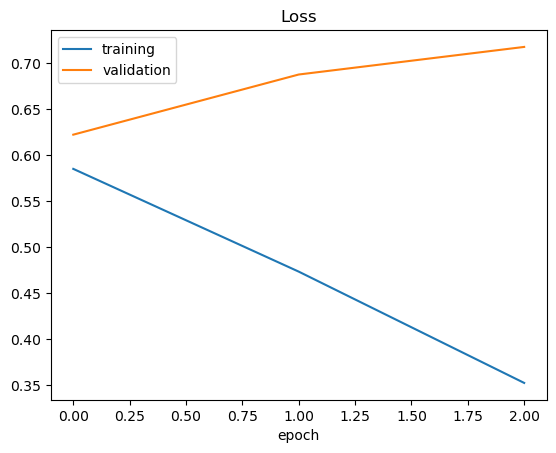

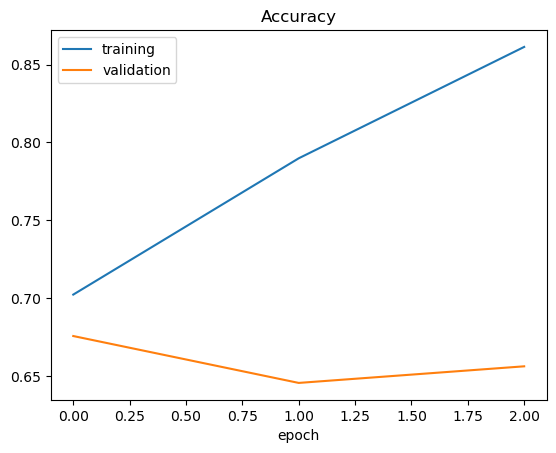

In [11]:
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history['accuracy'])
print(history.history['val_accuracy'])

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')


plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

In [ ]:
prd_df = pd.read_csv('/HugeDatasetPredictSample.csv')

In [13]:
val_text = prd_df['text']
val_label = prd_df['label']

In [14]:
val_text_sequences = tokenizer.texts_to_sequences(val_text)

val_text_padded = pad_sequences(val_text_sequences, maxlen=128)

In [15]:
test2_loss, test2_accuracy = model.evaluate(val_text_padded, val_label)

313/313 [==============================] - 11s 34ms/step - loss: 0.7599 - accuracy: 0.5440


In [16]:
pred = model.predict(val_text_padded)

313/313 [==============================] - 17s 48ms/step


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

In [18]:
binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

Accuracy on testing set: 0.544
Precision on testing set: 0.4411483253588517
Recall on testing set: 0.3299928418038654


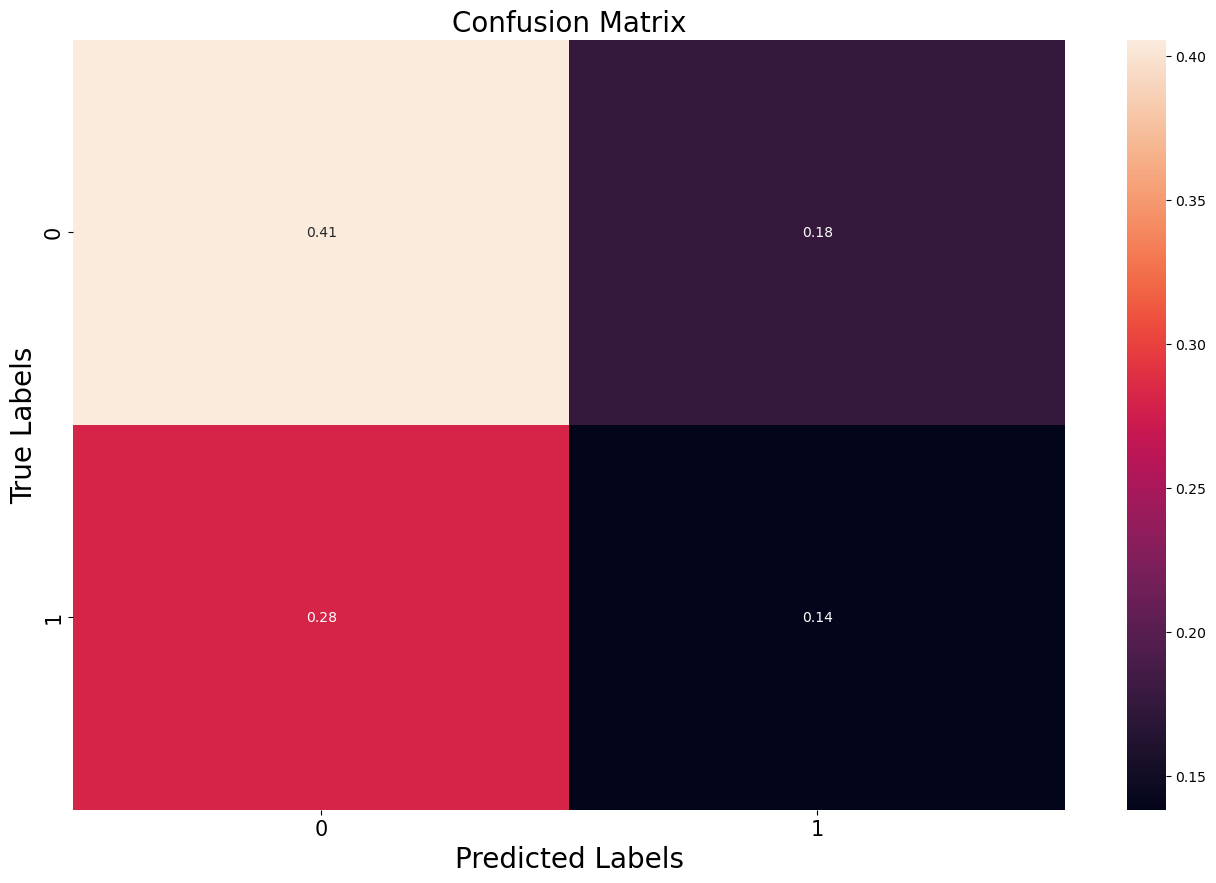

In [19]:
matrix = confusion_matrix(binary_predictions, val_label, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions, val_label))
print('Precision on testing set:', precision_score(binary_predictions, val_label))
print('Recall on testing set:', recall_score(binary_predictions, val_label))

In [20]:
print("Classification Report on First Test set\n")
print(classification_report(binary_predictions, val_label))

Classification Report on First Test set

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      5809
           1       0.44      0.33      0.38      4191

    accuracy                           0.54     10000
   macro avg       0.52      0.51      0.51     10000
weighted avg       0.53      0.54      0.53     10000



50/50 [==============================] - 2s 33ms/step
Accuracy on testing set: 0.6756587202007528
Precision on testing set: 0.6248196248196248
Recall on testing set: 0.6275362318840579
Classification Report on Training set

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       904
           1       0.62      0.63      0.63       690

    accuracy                           0.68      1594
   macro avg       0.67      0.67      0.67      1594
weighted avg       0.68      0.68      0.68      1594



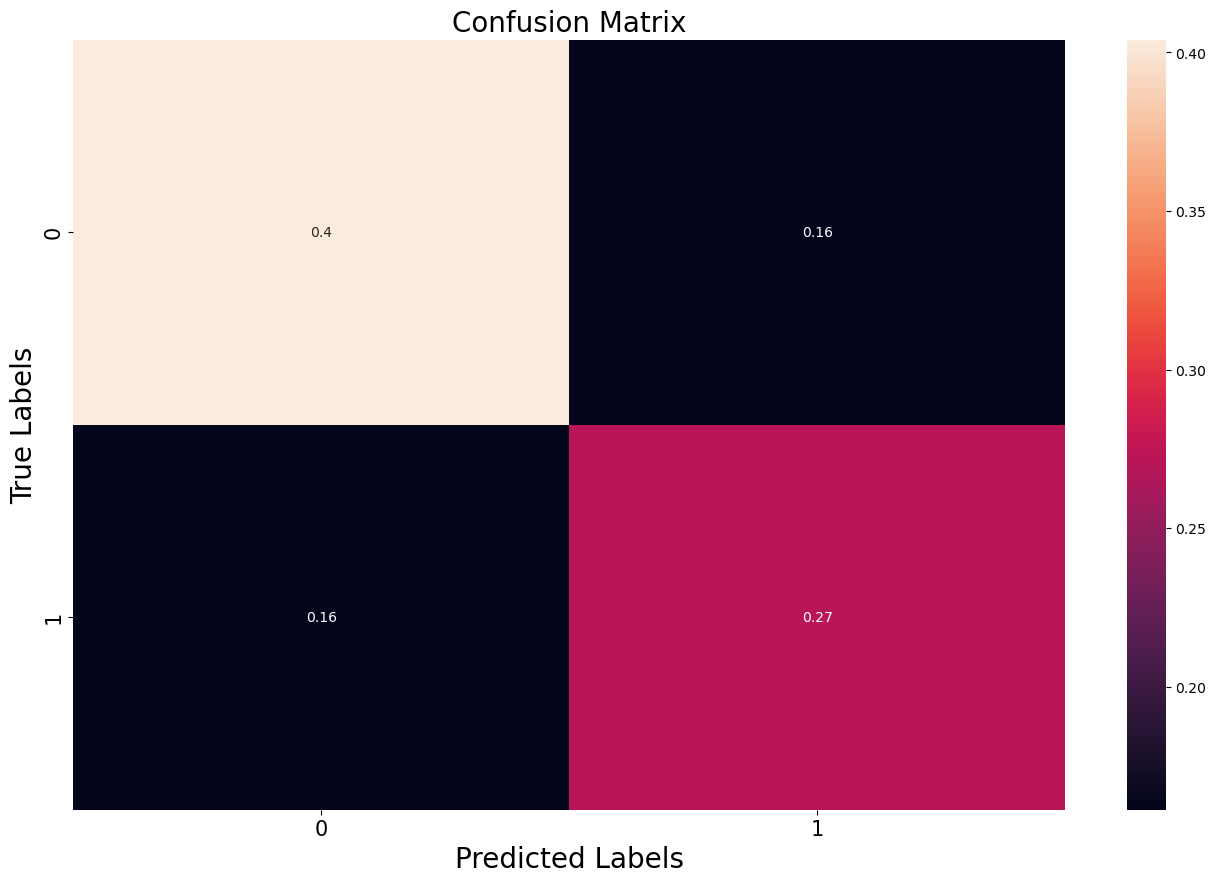

In [21]:
pred = model.predict(X_test_padded)

binary_predictions_Train = []

for i in pred:
    if i >= 0.5:
        binary_predictions_Train.append(1)
    else:
        binary_predictions_Train.append(0) 
        
matrix = confusion_matrix(binary_predictions_Train, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions_Train, y_test))
print('Precision on testing set:', precision_score(binary_predictions_Train, y_test))
print('Recall on testing set:', recall_score(binary_predictions_Train, y_test))

print("Classification Report on Training set\n")
print(classification_report(binary_predictions_Train, y_test))

2255/2255 [==============================] - 80s 35ms/step
Accuracy on testing set: 0.5806693098954723
Precision on testing set: 0.4724842343556298
Recall on testing set: 0.6215698787492023
Classification Report on Second Test set

              precision    recall  f1-score   support

           0       0.70      0.55      0.62     43928
           1       0.47      0.62      0.54     28206

    accuracy                           0.58     72134
   macro avg       0.58      0.59      0.58     72134
weighted avg       0.61      0.58      0.59     72134



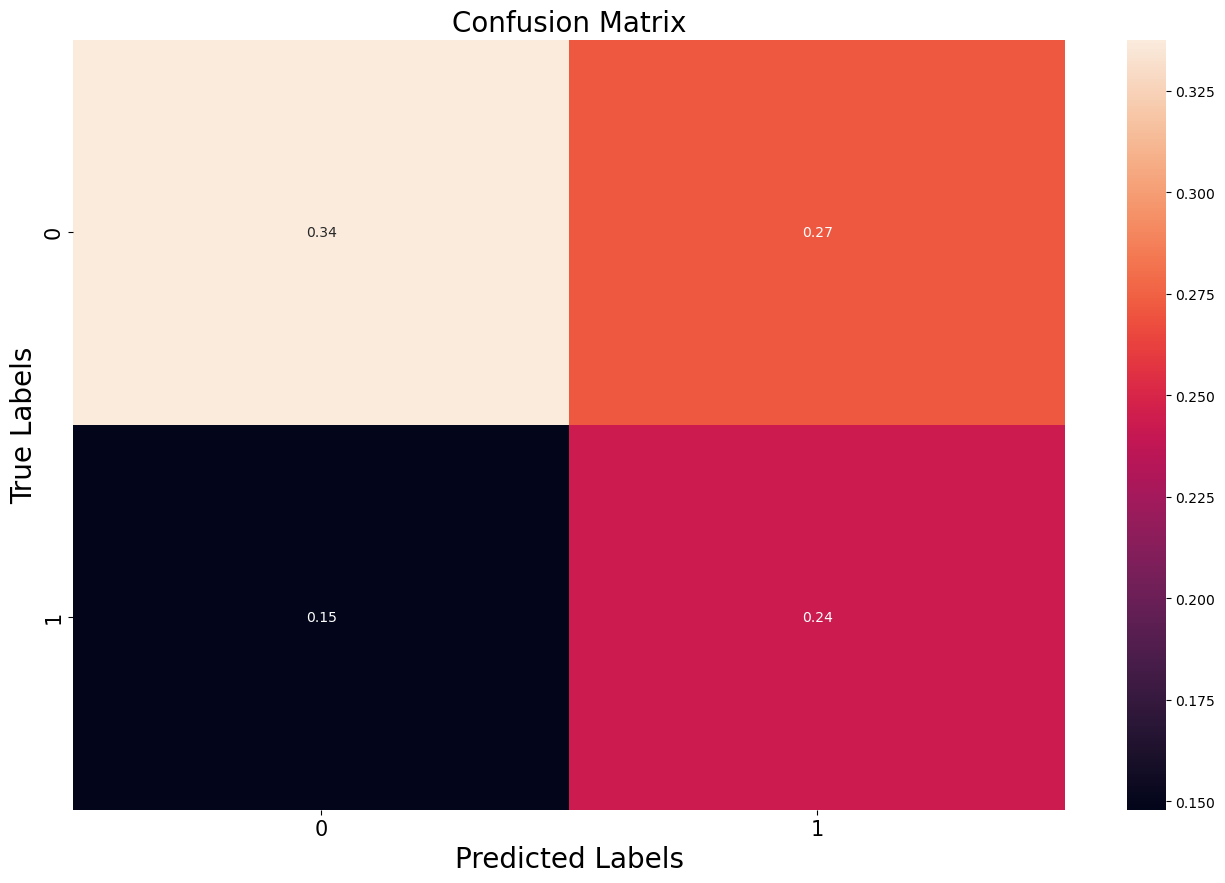

In [ ]:
val2_df = pd.read_csv('/WELFake_Dataset.csv')
val2_df.text = val2_df.text.astype(str)

val2_text = val2_df['text']
val2_label = val2_df['label']

val2_text_sequences = tokenizer.texts_to_sequences(val2_text)

val2_text_padded = pad_sequences(val2_text_sequences, maxlen=128)

pred_val2 = model.predict(val2_text_padded)

binary_predictions_val2 = []

for i in pred_val2:
    if i >= 0.5:
        binary_predictions_val2.append(1)
    else:
        binary_predictions_val2.append(0) 
        
matrix = confusion_matrix(binary_predictions_val2, val2_label, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions_val2, val2_label))
print('Precision on testing set:', precision_score(binary_predictions_val2, val2_label))
print('Recall on testing set:', recall_score(binary_predictions_val2, val2_label))

print("Classification Report on Second Test set\n")
print(classification_report(binary_predictions_val2, val2_label))

In [23]:
#import joblib

#filename = "LIAR_NoLemma_model_02.joblib"
#joblib.dump(model, filename)

INFO:tensorflow:Assets written to: ram://2d8c2b7f-77dd-4640-8246-f984506b3398/assets


INFO:tensorflow:Assets written to: ram://2d8c2b7f-77dd-4640-8246-f984506b3398/assets


['LIAR_NoLemma_model_02.joblib']